In [1]:
# Fun some setup for the project
# Silence annoying pytorch deprecated warnings
import warnings
warnings.filterwarnings("ignore")

from train import *
from create_graphs import *
from evaluate import *
%matplotlib inline

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print ('CUDA Available:', torch.cuda.is_available())

CUDA Available: True


In [2]:
# Generate the model datasets (i.e. the dataset used to train
# the model - normal data)
args_ladder_e, train_ladder_e, val_ladder_e, test_ladder_e = get_graph_data("ladder_extra", isModelDataset=True)
# Save the max_previous node to allow for model 
# compatability on future datasets
max_prev_node = args_ladder_e.max_prev_node

# Create dataset and dataloader object for the out of distribution ladder dataset
# Note that instead of passing in args.max_prev_node, we pass in the saved max_prev_node
# saved specifically for the enzyme dataset - hack to allow for GraphRNN to work on any dataset
train_dataset = Graph_sequence_sampler_pytorch_rand(train_ladder_e,max_prev_node=max_prev_node,max_num_node=args_ladder_e.max_num_node)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, num_workers=args_ladder_e.num_workers)

test_dataset = Graph_sequence_sampler_pytorch_rand(test_ladder_e, max_prev_node=max_prev_node,max_num_node=args_ladder_e.max_num_node)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, num_workers=args_ladder_e.num_workers)

# Model initialization
# Using GraphRNN

rnn = GRU_plain(input_size=args_ladder_e.max_prev_node, embedding_size=args_ladder_e.embedding_size_rnn,
                        hidden_size=args_ladder_e.hidden_size_rnn, num_layers=args_ladder_e.num_layers, has_input=True,
                        has_output=True, output_size=args_ladder_e.hidden_size_rnn_output).to(device)
output = GRU_plain(input_size=1, embedding_size=args_ladder_e.embedding_size_rnn_output,
                        hidden_size=args_ladder_e.hidden_size_rnn_output, num_layers=args_ladder_e.num_layers, has_input=True,
                        has_output=True, output_size=1).to(device)
# Let's see how the nlls of the ladder graphs compare to 
# the trained on enzymes.
# Note we pass in the args_enzy because the model we are
# using are trained in the enzyme dataset
train_nlls, train_avg_nlls = calc_nll(args_ladder_e, train_loader, rnn, output, max_iter=10, load_epoch=3000, log=1)

train_avg_nlls_iter = np.array(train_avg_nlls)
train_avg_nlls_iter = train_avg_nlls_iter.reshape((10, len(train_loader)))
train_avg_nlls_iter = np.mean(train_avg_nlls_iter, axis=0)

# Analysis of the test data set nlls.
# We really gotta train over more data!
test_nlls, test_avg_nlls = calc_nll(args_ladder_e, test_loader, rnn, output, load_epoch=3000, max_iter=10, log=1)

test_avg_nlls_iter = np.array(test_avg_nlls)
test_avg_nlls_iter = test_avg_nlls_iter.reshape((10, len(test_loader)))
test_avg_nlls_iter = np.mean(test_avg_nlls_iter, axis=0)

Average num nodes 60.0
total graph num: 1000
max number node: 60
max/min number edge: 158; 158
max previous node: 28
./model_save/GraphRNN_RNN_ladder_extra_4_128_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 1
Average Nll over train data: 251.37729810714723
Iteration: 2
Average Nll over train data: 252.2406459617615
Iteration: 3
Average Nll over train data: 252.69889671325683
Iteration: 4
Average Nll over train data: 252.4047611427307
Iteration: 5
Average Nll over train data: 251.78163610458375
Iteration: 6
Average Nll over train data: 251.79153955459594
Iteration: 7
Average Nll over train data: 253.2405751991272
Iteration: 8
Average Nll over train data: 251.2893557548523
Iteration: 9
Average Nll over train data: 254.33201789855957
Iteration: 10
Average Nll over train data: 251.9835802268982
./model_save/GraphRNN_RNN_ladder_extra_4_128_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 1
Average Nll over train data: 248.4665692138672
Iteration: 2
Average Nll over train data: 255

In [3]:
def plot_nlls(nlls, iterations, num_graphs):
    # Calculate also the nlls averaged over the iterations for each batch
    nlls_iter = np.mean(np.array(nlls).reshape(iterations, num_graphs), axis=0)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    # Plot the two distributions side by side
    sns.distplot(nlls, ax=ax[0], kde=True)
    ax[0].set_title("NLL Distribution across many permutations")
    ax[0].set_xlabel("Negative Log Likelihood")
    
    sns.distplot(nlls_iter, ax=ax[1], kde=True)
    ax[1].set_title("NLL Averaged Across Permutations")
    ax[1].set_xlabel("Negative Log Likelihood")
    
    return ax
    

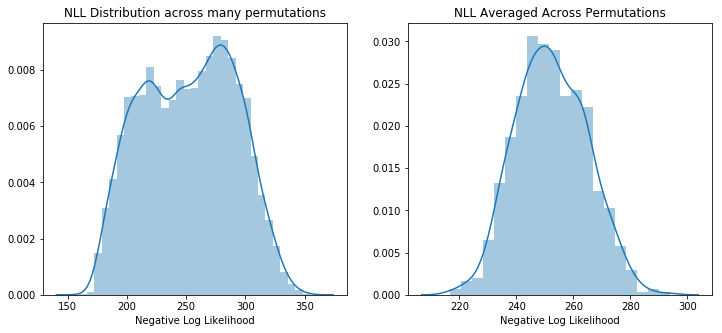

In [4]:
ax = plot_nlls(train_nlls, 10, len(train_loader))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1200088128>,
      dtype=object)

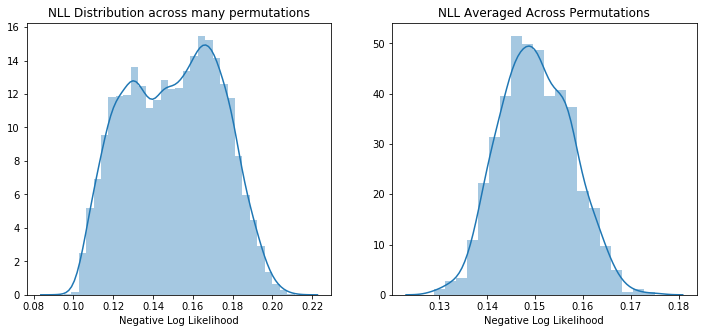

In [5]:
plot_nlls(train_avg_nlls, 10, len(train_loader))

In [6]:
def compare_dist(nlls, labels=['Nomarl', 'Anomalous'], title="Normal vs. Anomalous NLL Distributions"):
    fig, ax = plt.subplots()
    for i in range(len(nlls)):
        sns.distplot(nlls[i], ax=ax, kde=True, label=labels[i])
    ax.legend()
    ax.set_xlabel("Negative Log Likelihood")
    ax.set_title(title)
    return fig, ax

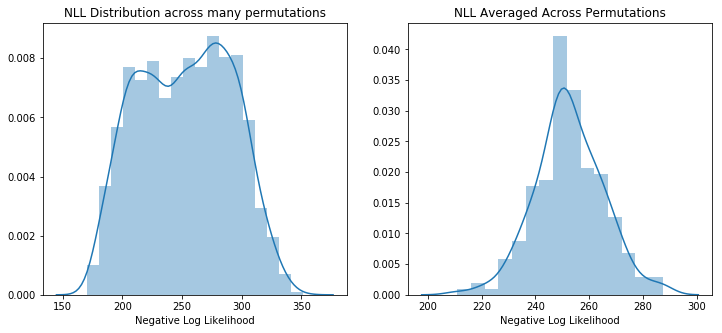

In [7]:
ax_test = plot_nlls(test_nlls, 10, len(test_loader))

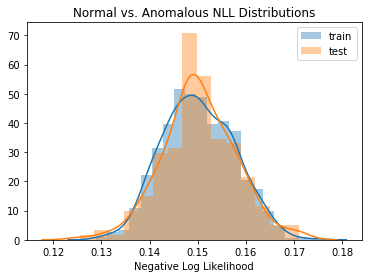

In [8]:
fig, ax_compare = compare_dist([train_avg_nlls_iter, test_avg_nlls_iter], ['train', 'test'])
fig.savefig("Train_Type_2a")

In [9]:
# Now let's try using a different dataset on the same GraphRNN
# trained on the enzyemes small dataset. By plotting the distribution
# over the nlls of this test set from a different family, hopefully
# we can see the success of the generative model
args_rand, graphs_rand = get_graph_data("random_6_60", isModelDataset=False)

# Create dataset and dataloader object for the out of distribution ladder dataset
# Note that instead of passing in args.max_prev_node, we pass in the saved max_prev_node
# saved specifically for the enzyme dataset - hack to allow for GraphRNN to work on any dataset
rand_dataset = Graph_sequence_sampler_pytorch_rand(graphs_rand,max_prev_node=max_prev_node,max_num_node=args_rand.max_num_node)
rand_loader = torch.utils.data.DataLoader(rand_dataset, batch_size=1, num_workers=args_rand.num_workers)

# Let's see how the nlls of the ladder graphs compare to 
# the trained on enzymes.
# Note we pass in the args_enzy because the model we are
# using are trained in the enzyme dataset
rand_nlls, rand_avg_nlls = calc_nll(args_ladder_e, rand_loader, rnn, output, max_iter=10, train_dataset="ladder_extra", log=1)

rand_avg_nlls_iter = np.array(rand_avg_nlls)
rand_avg_nlls_iter = rand_avg_nlls_iter.reshape((10, len(rand_loader)))
rand_avg_nlls_iter = np.mean(rand_avg_nlls_iter, axis=0)


Average num nodes 60.0
total graph num: 1000
max number node: 60
max/min number edge: 180; 180
max previous node: None
./model_save/GraphRNN_RNN_ladder_extra_4_128_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 1
Average Nll over train data: 843.6535725708007
Iteration: 2
Average Nll over train data: 844.5892423706055
Iteration: 3
Average Nll over train data: 844.4609085083008
Iteration: 4
Average Nll over train data: 844.5872005615234
Iteration: 5
Average Nll over train data: 845.4811437988282
Iteration: 6
Average Nll over train data: 841.44525
Iteration: 7
Average Nll over train data: 844.9212247314454
Iteration: 8
Average Nll over train data: 842.5562253417969
Iteration: 9
Average Nll over train data: 847.3453264770508
Iteration: 10
Average Nll over train data: 848.7168586425781


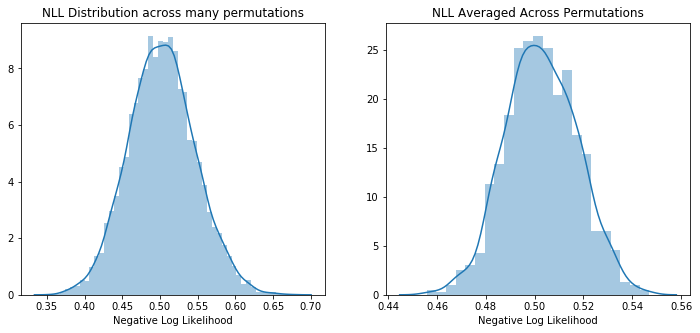

In [10]:
ax_test = plot_nlls(rand_avg_nlls, 10, len(rand_loader))

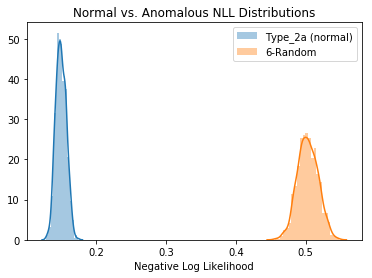

In [11]:
fig, ax_compare = compare_dist([train_avg_nlls_iter, rand_avg_nlls_iter], ['Type_2a (normal)', '6-Random'])
fig.savefig("Type_2a-VS-6_Random")

In [12]:
# Starting with enzyme with label 2
args_ladder_t, graphs_ladder_t = get_graph_data("ladder_tree_10", isModelDataset=False)

# Create dataset and dataloader object for the out of distribution ladder dataset
# Note that instead of passing in args.max_prev_node, we pass in the saved max_prev_node
# saved specifically for the enzyme dataset - hack to allow for GraphRNN to work on any dataset
ladder_t_dataset = Graph_sequence_sampler_pytorch_rand(graphs_ladder_t,max_prev_node=max_prev_node,max_num_node=args_ladder_t.max_num_node)
ladder_t_loader = torch.utils.data.DataLoader(ladder_t_dataset, batch_size=1, num_workers=args_ladder_t.num_workers)

# Let's see how the nlls of the ladder graphs compare to 
# the trained on enzymes.
# Note we pass in the args_enzy because the model we are
# using are trained in the enzyme dataset
ladder_t_nlls, ladder_t_avg_nlls = calc_nll(args_ladder_e, ladder_t_loader, rnn, output, max_iter=10, load_epoch=3000, train_dataset="ladder_extra", log=1)

ladder_t_avg_nlls_iter = np.array(ladder_t_avg_nlls)
ladder_t_avg_nlls_iter = ladder_t_avg_nlls_iter.reshape((10, len(ladder_t_loader)))
ladder_t_avg_nlls_iter = np.mean(ladder_t_avg_nlls_iter, axis=0)


Average num nodes 60.0
total graph num: 1000
max number node: 60
max/min number edge: 180; 180
max previous node: 28
./model_save/GraphRNN_RNN_ladder_extra_4_128_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 1
Average Nll over train data: 475.9390365600586
Iteration: 2
Average Nll over train data: 477.9375801086426
Iteration: 3
Average Nll over train data: 476.64617379760745
Iteration: 4
Average Nll over train data: 476.3309762878418
Iteration: 5
Average Nll over train data: 477.35358996582033
Iteration: 6
Average Nll over train data: 477.2103374633789
Iteration: 7
Average Nll over train data: 477.70170318603516
Iteration: 8
Average Nll over train data: 476.89201290893556
Iteration: 9
Average Nll over train data: 477.378509765625
Iteration: 10
Average Nll over train data: 476.7955745239258


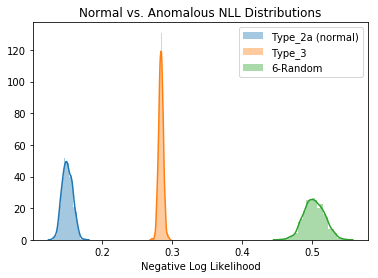

In [13]:
fig, ax_compare = compare_dist([train_avg_nlls_iter, ladder_t_avg_nlls_iter ,rand_avg_nlls_iter], ['Type_2a (normal)', 'Type_3', '6-Random'])
fig.savefig("Type_2a-VS-Type_3-VS-6_Random")

In [14]:
# Starting with enzyme with label 2
args_ladder_e_circ, graphs_ladder_e_circ = get_graph_data("ladder_extra_circular", isModelDataset=False)

# Create dataset and dataloader object for the out of distribution ladder dataset
# Note that instead of passing in args.max_prev_node, we pass in the saved max_prev_node
# saved specifically for the enzyme dataset - hack to allow for GraphRNN to work on any dataset
ladder_e_circ_dataset = Graph_sequence_sampler_pytorch_rand(graphs_ladder_e_circ,max_prev_node=max_prev_node,max_num_node=args_ladder_e_circ.max_num_node)
ladder_e_circ_loader = torch.utils.data.DataLoader(ladder_e_circ_dataset, batch_size=1, num_workers=args_ladder_e_circ.num_workers)

# Let's see how the nlls of the ladder graphs compare to 
# the trained on enzymes.
# Note we pass in the args_enzy because the model we are
# using are trained in the enzyme dataset
ladder_e_circ_nlls, ladder_e_circ_avg_nlls = calc_nll(args_ladder_e, ladder_e_circ_loader, rnn, output, max_iter=10, load_epoch=3000, train_dataset="ladder_extra", log=1)

ladder_e_circ_avg_nlls_iter = np.array(ladder_e_circ_avg_nlls)
ladder_e_circ_avg_nlls_iter = ladder_e_circ_avg_nlls_iter.reshape((10, len(ladder_e_circ_loader)))
ladder_e_circ_avg_nlls_iter = np.mean(ladder_e_circ_avg_nlls_iter, axis=0)


Average num nodes 60.0
total graph num: 1000
max number node: 60
max/min number edge: 170; 170
max previous node: 28
./model_save/GraphRNN_RNN_ladder_extra_4_128_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 1
Average Nll over train data: 413.74091107177736
Iteration: 2
Average Nll over train data: 413.83766552734374
Iteration: 3
Average Nll over train data: 412.91809451293943
Iteration: 4
Average Nll over train data: 413.4127010498047
Iteration: 5
Average Nll over train data: 412.97696084594725
Iteration: 6
Average Nll over train data: 414.13185372924806
Iteration: 7
Average Nll over train data: 413.74292474365234
Iteration: 8
Average Nll over train data: 413.29112658691406
Iteration: 9
Average Nll over train data: 413.47356240844726
Iteration: 10
Average Nll over train data: 412.91140899658205


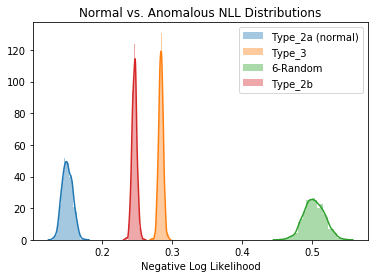

In [15]:
ax_compare = compare_dist([train_avg_nlls_iter, 
                           ladder_t_avg_nlls_iter,
                           rand_avg_nlls_iter, 
                           ladder_e_circ_avg_nlls_iter], 
                          ['Type_2a (normal)', 'Type_3', 
                           '6-Random', 'Type_2b'])
fig.savefig("Type_2a-VS-Type_3-VS-6_Random-VS-Type_2b")

In [16]:
# Starting with enzyme with label 2
args_ladder_e_full_circ, graphs_ladder_e_full_circ = get_graph_data("ladder_extra_full_circular", isModelDataset=False)

# Create dataset and dataloader object for the out of distribution ladder dataset
# Note that instead of passing in args.max_prev_node, we pass in the saved max_prev_node
# saved specifically for the enzyme dataset - hack to allow for GraphRNN to work on any dataset
ladder_e_full_circ_dataset = Graph_sequence_sampler_pytorch_rand(graphs_ladder_e_full_circ,max_prev_node=max_prev_node,max_num_node=args_ladder_e_full_circ.max_num_node)
ladder_e_full_circ_loader = torch.utils.data.DataLoader(ladder_e_full_circ_dataset, batch_size=1, num_workers=args_ladder_e_full_circ.num_workers)

# Let's see how the nlls of the ladder graphs compare to 
# the trained on enzymes.
# Note we pass in the args_enzy because the model we are
# using are trained in the enzyme dataset
ladder_e_full_circ_nlls, ladder_e_full_circ_avg_nlls = calc_nll(args_ladder_e, 
                                                                ladder_e_full_circ_loader, 
                                                                rnn, output, max_iter=10, 
                                                                load_epoch=3000, train_dataset="ladder_extra", log=1)

ladder_e_full_circ_avg_nlls_iter = np.array(ladder_e_full_circ_avg_nlls)
ladder_e_full_circ_avg_nlls_iter = ladder_e_full_circ_avg_nlls_iter.reshape((10, len(ladder_e_full_circ_loader)))
ladder_e_full_circ_avg_nlls_iter = np.mean(ladder_e_full_circ_avg_nlls_iter, axis=0)


Average num nodes 60.0
total graph num: 1000
max number node: 60
max/min number edge: 180; 180
max previous node: 28
./model_save/GraphRNN_RNN_ladder_extra_4_128_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 1
Average Nll over train data: 474.87847341918945
Iteration: 2
Average Nll over train data: 474.2018352661133
Iteration: 3
Average Nll over train data: 474.68458111572266
Iteration: 4
Average Nll over train data: 474.3723496398926
Iteration: 5
Average Nll over train data: 473.32811715698244
Iteration: 6
Average Nll over train data: 473.9908769836426
Iteration: 7
Average Nll over train data: 473.47281506347656
Iteration: 8
Average Nll over train data: 474.39765292358396
Iteration: 9
Average Nll over train data: 474.1572062683106
Iteration: 10
Average Nll over train data: 474.4000467224121


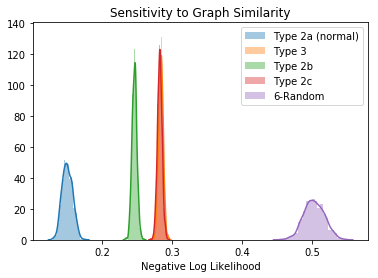

In [17]:
fig, ax_compare = compare_dist([train_avg_nlls_iter, 
                           ladder_t_avg_nlls_iter,
                           ladder_e_circ_avg_nlls_iter,
                           ladder_e_full_circ_avg_nlls_iter,
                           rand_avg_nlls_iter], 
                          ['Type 2a (normal)', 'Type 3', 'Type 2b',
                          'Type 2c', '6-Random'],
                              'Sensitivity to Graph Similarity')
fig.savefig("NLL_Figures/Type_2a-VS-Type_3-VS-6_Random-VS-Type_2b-VS-Type_2c")

Text(0.5,1,'Comparision of avg clusering coefficients')

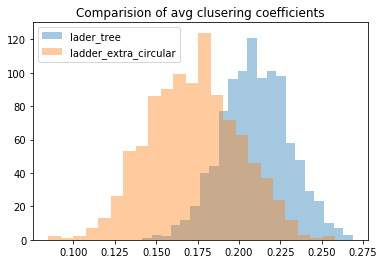

In [18]:
# Let us look at the differences between the graphs for train and test at a very basic level
metrics = compare_graph_list(graphs_ladder_t, graphs_ladder_e_circ)
#print (metrics['diff_degree'])
#print (metrics['diff_clust'])


# Plot the clust distributions

fig2, ax2 = plt.subplots()
labels = ['lader_tree', 'ladder_extra_circular']
clust = metrics['clust_dist']
for i in range(len(clust)):
    sns.distplot(clust[i], ax=ax2, kde=False, label=labels[i])
ax2.legend()
ax2.set_title("Comparision of avg clusering coefficients")

(6.0, 6.0)
(0.2100255026455026, 0.1871026455026455)


Text(0.5,1,'Comparision of avg clusering coefficients')

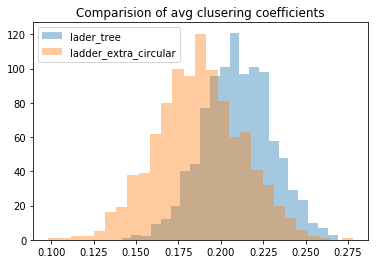

In [19]:
# Let us look at the differences between the graphs for train and test at a very basic level
metrics = compare_graph_list(graphs_ladder_t, graphs_ladder_e_full_circ)
print (metrics['avg_degree'])
print (metrics['avg_clust'])


# Plot the clust distributions

fig2, ax2 = plt.subplots()
labels = ['lader_tree', 'ladder_extra_circular']
clust = metrics['clust_dist']
for i in range(len(clust)):
    sns.distplot(clust[i], ax=ax2, kde=False, label=labels[i])
ax2.legend()
ax2.set_title("Comparision of avg clusering coefficients")